# Forecast demo
Here we load the trained Aardvark Weather model and produce a global and station forecast using the sample data. 

In [24]:
import sys
sys.path.append("../aardvark")

import pickle
import numpy as np
from e2e_model import *

import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

Check a GPU is available

In [25]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available, cannot produce forecast.")

GPU is available.
GPU name: NVIDIA A100 80GB PCIe


## Generate predictions

Load the sample data (for a detailed analysis and visualisation of the contents of this dataset see data_demo.ipynb)

In [26]:
with open("../data/sample_data_final.pkl", "rb") as fp:
    data = pickle.load(fp)

Load the model to generate predictions at one day leadtime. First select which varaible to generate station forecasts for.

In [27]:
local_forecast_var = "tas"  # Model weights included for windspeed (ws) and 2tm (tas)

model = ConvCNPWeatherE2E(
    device="cuda",
    lead_time=1,
    se_model_path="../trained_models/encoder",
    forecast_model_path="../trained_models/processor",
    sf_model_path=f"../trained_models/decoder/{local_forecast_var}/",
    return_gridded=True,
    aux_data_path="../data/",
)

Run the model to generate a forecast the sample data. This outputs the station forecast, gridded forevast and initial state

In [35]:
station_forecast, global_forecast, initial_state = model(data)

## Visualise model predictions

First look at the gridded forecasts. Visualise several variables

In [36]:
vars = [
    "u10",
    "v10",
    "t2m",
    "mslp",
    "z200",
    "z500",
    "z700",
    "z850",
    "q200",
    "q500",
    "q700",
    "q850",
    "t200",
    "t500",
    "t700",
    "t850",
    "u200",
    "u500",
    "u700",
    "u850",
    "v200",
    "v500",
    "v700",
    "v850",
]

var_index_mapping = {k: v for v, k in enumerate(vars)}

In [37]:
lon = np.linspace(0, 359, 240)
lat = np.linspace(-90, 90, 121)

Select the variable and data to plot. To plot another variable simply change the variable argument below. 

In [38]:
variable = "u10"
var_index = var_index_mapping[variable]
initial_state_var = initial_state[0, ..., var_index].detach().cpu().numpy()
global_forecast_var = global_forecast[0, ..., var_index].detach().cpu().numpy()
colorscale_mag = np.max(np.abs(initial_state_var))

Plot the initial state

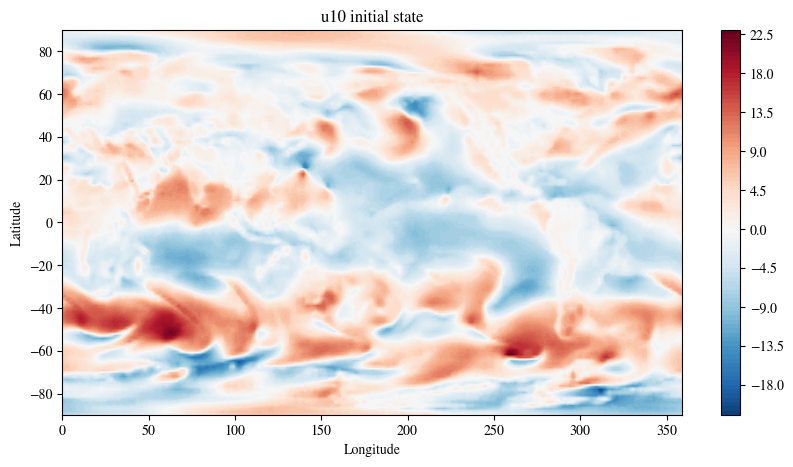

In [39]:
fig = plt.figure(figsize=(10, 5))
plot_channel = 10
p = plt.contourf(
    lon,
    lat,
    initial_state_var,
    levels=100,
    vmax=colorscale_mag,
    vmin=-colorscale_mag,
    cmap="RdBu_r",
)
cbar = fig.colorbar(p)
# cbar.set_label('(m/s)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"{variable} initial state")
plt.show()

Plot the prediction at one day leadtime

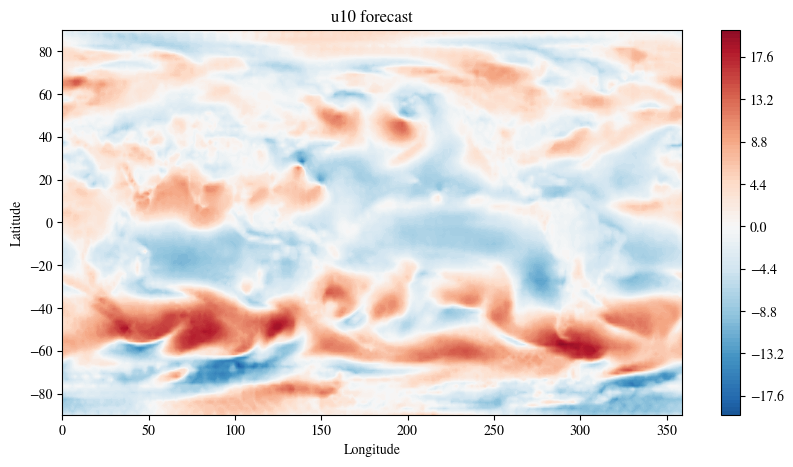

In [40]:
fig = plt.figure(figsize=(10, 5))
plot_channel = 10
p = plt.contourf(
    lon,
    lat,
    global_forecast_var,
    levels=100,
    vmax=colorscale_mag,
    vmin=-colorscale_mag,
    cmap="RdBu_r",
)
cbar = fig.colorbar(p)
# cbar.set_label('(m/s)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"{variable} forecast")
plt.show()

The model also returns the station forecasts for T2M

In [42]:
STATION_LON_LAT_SF = 360
HADISD_SCALING_FACTOR = 10
# Factors to unnormalise predictions
mean = np.load(f"../data/norm_factors/mean_hadisd_{local_forecast_var}.npy")
std = np.load(f"../data/norm_factors/std_hadisd_{local_forecast_var}.npy")

In [43]:
station_forecast = (
    station_forecast.detach().cpu() * std + mean
) * HADISD_SCALING_FACTOR

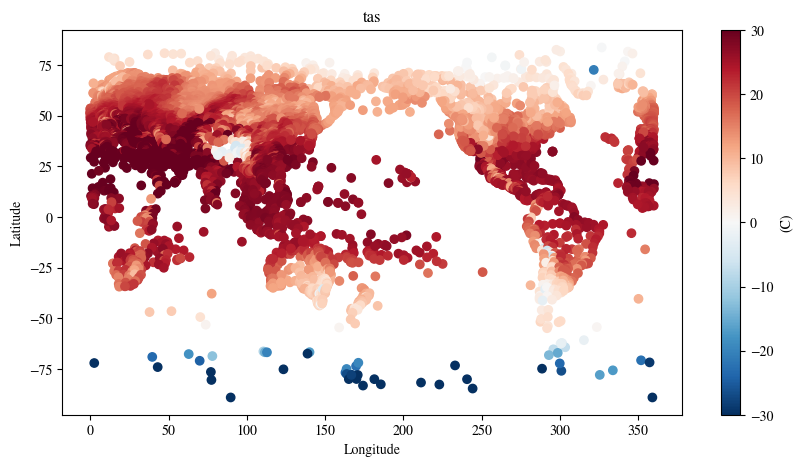

In [44]:
fig = plt.figure(figsize=(10, 5))
plot_channel = 10
p = plt.scatter(
    data["downscaling"]["x_target"][0, 0, :].detach().cpu() * STATION_LON_LAT_SF,
    data["downscaling"]["x_target"][0, 1, :].detach().cpu() * STATION_LON_LAT_SF,
    c=station_forecast[0, :],
    vmax=30,
    vmin=-30,
    cmap="RdBu_r",
)
cbar = fig.colorbar(p)
cbar.set_label("(C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"{local_forecast_var}")
plt.show()